# Anwendung und Vergleich von Machine Learning und Deep Learning Algorithmen zur Vorhersage von COVID-19 Kennzahlen

## Neuronale Netze

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from matplotlib import pyplot

%matplotlib inline

## Laden der Daten

In [2]:
# Load the data from disk
# X_train = np.load('../preprocessing/X_train.npy')
# X_test = np.load('../preprocessing/X_test.npy')
# y_train = np.load('../preprocessing/y_train.npy')
# y_test = np.load('../preprocessing/y_test.npy')

data = np.load('../preprocessing/dataset.npy')

In [3]:
# Move first columns (= cases) to the end of the array
permutations = [1,2,3,4,5,6,7,8,9,10,0]
data = data[:, permutations]

In [4]:
# Function to transform data into sequences
def transform_to_sequences(data, n_in=1, n_out=1, dropnan=True):
	# n_vars corresponds to the number of features
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	
	# input sequence (t-n, ..., t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence(t, t+1, ..., t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
		
	# put all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		# drop all rows that contains Nan values (1st row)
		agg.dropna(inplace=True)
	return agg

In [5]:
# Split data in training and test set
num_datapoints = data.shape[0]
num_training = int(num_datapoints*0.7)

train, test = data[:num_training], data[num_training:]

# Verify the shapes of train and test
print(train.shape)
print(test.shape)

(462, 11)
(199, 11)


In [6]:
# Scale the datasets using MinMax scaler (as this scaler transforms the features to a range from 0 to 1 - so all the features have the same range)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

In [7]:
# Transform the data into sequences
train_transformed = transform_to_sequences(train_scaled, 14, 1)
test_transformed = transform_to_sequences(test_scaled, 14, 1)

In [8]:
# Verify the shapes of train_transformed and test_transformed
print(train_transformed.shape)
print(test_transformed.shape)

(448, 165)
(185, 165)


In [9]:
# Split data in input X and output y
n_input_timestamps = 14
n_features_per_timestamp = 11
n_input_features = n_input_timestamps * n_features_per_timestamp

In [10]:
X_train, y_train = train_transformed.values[:, :n_input_features], train_transformed.values[:, n_input_features:]
print(X_train.shape)
print(y_train.shape)

(448, 154)
(448, 11)


In [12]:
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272483,0.115409,0.000000,0.018068
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299731,0.126950,0.018519,0.019874
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.326979,0.138491,0.027778,0.031571
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354228,0.150032,0.037037,0.033853
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.381476,0.161573,0.027778,0.040890


In [11]:
# Drop columns 0 to 9 as we just want to predict feature #10 (= cases)
y_train = y_train[:, -1]

In [12]:
X_test, y_test = test_transformed.values[:, :n_input_features], test_transformed.values[:, n_input_features:]
print(X_test.shape)
print(y_test.shape)

(185, 154)
(185, 11)


In [15]:
pd.DataFrame(y_test).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.867587,0.000014,0.733161,0.474988,1.000000,0.000371,0.435694,0.248276,0.133835,0.00000,0.021300
1,0.850201,0.000000,0.859001,0.599870,0.311022,0.000604,0.592891,0.241379,0.129780,0.03125,0.013778
2,0.806728,0.000000,0.884554,0.493402,0.183680,0.000868,0.490748,0.206897,0.122248,0.12500,0.010452
3,0.805378,0.000000,0.939504,0.270029,0.202176,0.001949,0.263427,0.203448,0.103708,0.09375,0.007760
4,0.755921,0.000000,0.929662,1.000000,0.247540,0.002303,1.000000,0.200000,0.095017,0.09375,0.007126


In [13]:
# Drop columns 0 to 9 as we just want to predict feature #10 (= cases)
y_test = y_test[:, -1]

In [14]:
# Reshape data to fit into the LSTM model (dimension must be [samples, time steps, features])
X_train_lstm = X_train.reshape((X_train.shape[0], n_input_timestamps, n_features_per_timestamp))
y_train_lstm = y_train.reshape((y_train.shape[0], 1))

X_test_lstm = X_test.reshape((X_test.shape[0], n_input_timestamps, n_features_per_timestamp))
y_test_lstm = y_test.reshape((y_test.shape[0], 1))

In [15]:
# Reshape data to fit into CNN model (dimension must be [samples, time steps, features])
X_train_cnn = X_train.reshape((X_train.shape[0], n_input_timestamps, n_features_per_timestamp))
y_train_cnn = y_train.reshape((y_train.shape[0], 1))

X_test_cnn = X_test.reshape((X_test.shape[0], n_input_timestamps, n_features_per_timestamp))
y_test_cnn = y_test.reshape((y_test.shape[0], 1))

## Modelle

### Convolutional Neuronal Network (CNN)

In [16]:
# Implementation is based on https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
def create_cnn_model(n_filters, n_kernel, activation_conv, pool_size, activation_dense, optimizer):
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation=activation_conv, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(50, activation=activation_dense))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

### Recurrent Neural Network (mit LSTM)

In [17]:
# Implementation is based on https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def create_lstm_model(n_neurons, optimizer):
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

## Optimierung der Hyperparameter
Neuronale Netzwerke verfügen über mehrere Hyperparameter (z.B. Anzahl der Layer, Anzahl der Neuronen pro Layer, Aktivierungsfunktion, Optimizer, Batch Size, etc.), die massgeblich die Performance eines Modells beeinflussen können. Aus diesem Grund gilt es diese zu optimieren. Dazu wird oft 'Grid Search' verwendet.


### Optimierung des CNN

Folgende Hyperparameter werden für das CNN optimiert:
- n_filters: Anzahl der Filter
- n_kernel: Grösse der Filter
- n_epochs: Anzahl Trainings-Epochen
- n_batch: Grösse des Mini-Batches
- pool_size: Grösse des Pooling Fensters
- activation_conv: Aktivierungsfunktion des Convolution Layers
- activation_dense: Aktivierungsfunktion des Dense Layers
- optimizer: Optimierungsfunktion des Modells

In [18]:
def get_model_configs_cnn():
    n_filter = [32, 64, 128, 256]
    n_kernel = [2, 3, 5, 7]
    n_epoches = [300, 500, 1000]
    n_batch = [32, 64, 128]
    pool_size = [2]
    activation_conv = ['relu']
    activation_dense = ['relu']
    optimizer = ['sgd', 'adam', 'rmsprop']

    configs = list()
    for a in n_filter:
        for b in n_kernel:
            for c in n_epoches:
                for d in n_batch:
                    for e in pool_size:
                        for f in activation_conv:
                            for g in activation_dense:
                                for h in optimizer:
                                    cfg = [a,b,c,d,e,f,g,h]
                                    configs.append(cfg)
    
    print('Number of configs: %d' % len(configs))
    return configs

In [19]:
def optimize_parameters_cnn(config):
    # Unpack the config
    n_filters, n_kernel, n_epochs, n_batch, pool_size, activation_conv, activation_dense, optimizer = config

    # Build the model
    model = create_cnn_model(n_filters, n_kernel, activation_conv, pool_size, activation_dense, optimizer)

    # Perform cross validation
    scores = []
    splits = TimeSeriesSplit(n_splits=5)
    for train_index, val_index in splits.split(X_train_cnn):
        X_tr, X_val = X_train_cnn[train_index], X_train_cnn[val_index]
        y_tr, y_val = y_train_cnn[train_index], y_train_cnn[val_index]

        history = model.fit(X_tr, y_tr, epochs=n_epochs, batch_size=n_batch, shuffle=False)
        score = model.evaluate(X_val, y_val, verbose=0)
        scores.append(score)
    
    # Calculate mean of the scores
    avg_score = sum(scores) / len(scores)

    return avg_score

In [20]:
model_configs_cnn = get_model_configs_cnn()

scores_cnn = []
for cfg in model_configs_cnn:
    score = optimize_parameters_cnn(cfg)
    scores_cnn.append(score)

Number of configs: 3
Epoch 1/300


2022-01-02 22:51:01.407412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 2/300
2/2 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 3/300
2/2 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 4/300
2/2 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 5/300
2/2 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 6/300
2/2 [==============================] - 0s 3ms/step - loss: 8.1524e-04
Epoch 7/300
2/2 [==============================] - 0s 4ms/step - loss: 6.6039e-04
Epoch 8/300
2/2 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/300
2/2 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/300
2/2 [==============================] - 0s 3ms/step - loss: 9.7215e-04
Epoch 11/300
2/2 [==============================] - 0s 14ms/step - loss: 5.5981e-04
Epoch 12/300
2/2 [==============================] - 0s 3ms/step - loss: 4.4431e-04
Epoch 13/300
2/2 [==============================] - 

In [44]:
# Find top score (= smallest loss)
best_score = sorted(range(len(scores_cnn)), key=lambda i: scores_cnn[i])[0]

In [46]:
# Find corresponding config for top score
model_configs_cnn[best_score]

[64, 5, 300, 64, 2, 'relu', 'relu', 'adam']

### Optimierung des LSTM

Folgende Hyperparameter werden für das LSTM optimiert:
- n_neurons: Anzahl Neuronen pro Layer
- n_epochs: Anzahl Trainings-Epochen
- n_batch: Grösse des Mini-Batches
- optimizer: Optimierungsfunktion des Modells

In [33]:
def get_model_configs_lstm():
    '''
    n_neurons = [10, 20, 50, 100, 200]
    n_epoches = [300, 500, 1000]
    n_batch = [32, 64, 128]
    optimizer = ['sgd', 'adam', 'rmsprop']
    '''

    n_neurons = [10, 20, 50, 100]
    n_epoches = [300]
    n_batch = [64]
    optimizer = ['adam']

    configs = list()
    for a in n_neurons:
        for b in n_epoches:
            for c in n_batch:
                for d in optimizer:
                    cfg = [a,b,c,d]
                    configs.append(cfg)
    
    print('Number of configs: %d' % len(configs))
    return configs

In [34]:
def optimize_parameters_lstm(config):
    # Unpack the config
    n_neurons, n_epochs, n_batch, optimizer = config

    # Build the model
    model = create_lstm_model(n_neurons, optimizer)

    # Perform cross validation
    scores = []
    splits = TimeSeriesSplit(n_splits=5)
    for train_index, val_index in splits.split(X_train_lstm):
        X_tr, X_val = X_train_lstm[train_index], X_train_lstm[val_index]
        y_tr, y_val = y_train_lstm[train_index], y_train_lstm[val_index]

        history = model.fit(X_tr, y_tr, epochs=n_epochs, batch_size=n_batch, shuffle=False)
        score = model.evaluate(X_val, y_val, verbose=0)
        scores.append(score)
    
    # Calculate mean of the scores
    avg_score = sum(scores) / len(scores)

    return avg_score

In [35]:
model_configs_lstm = get_model_configs_lstm()

scores_lstm = []
for cfg in model_configs_lstm:
    score = optimize_parameters_lstm(cfg)
    scores_lstm.append(score)

Number of configs: 4
Epoch 1/300
2/2 [==============================] - 2s 8ms/step - loss: 0.0844
Epoch 2/300
2/2 [==============================] - 0s 8ms/step - loss: 0.0738
Epoch 3/300
2/2 [==============================] - 0s 10ms/step - loss: 0.0652
Epoch 4/300
2/2 [==============================] - 0s 9ms/step - loss: 0.0577
Epoch 5/300
2/2 [==============================] - 0s 9ms/step - loss: 0.0510
Epoch 6/300
2/2 [==============================] - 0s 7ms/step - loss: 0.0452
Epoch 7/300
2/2 [==============================] - 0s 8ms/step - loss: 0.0400
Epoch 8/300
2/2 [==============================] - 0s 8ms/step - loss: 0.0354
Epoch 9/300
2/2 [==============================] - 0s 7ms/step - loss: 0.0313
Epoch 10/300
2/2 [==============================] - 0s 8ms/step - loss: 0.0278
Epoch 11/300
2/2 [==============================] - 0s 8ms/step - loss: 0.0247
Epoch 12/300
2/2 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 13/300
2/2 [=====================

In [39]:
# Find top score (= smallest loss)
best_score = sorted(range(len(scores_lstm)), key=lambda i: scores_lstm[i])[0]

In [42]:
# Find corresponding config for top score
model_configs_lstm[best_score]

[100, 300, 64, 'adam']

## Training der Modelle

### Training des CNN 

In [47]:
# Train CNN model with the best parameters from GridSearch
model_cnn_best = create_cnn_model(64, 5, 'relu', 2, 'relu', 'adam')
history_cnn = model_cnn_best.fit(X_train_cnn, y_train_cnn, epochs=300, batch_size=64, shuffle=False)

Epoch 1/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0405
Epoch 2/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 3/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 4/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 5/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 6/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 7/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 8/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 9/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 10/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 11/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 12/300
7/7 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 13/300
7/7 [==============================] - 0s 3ms/st

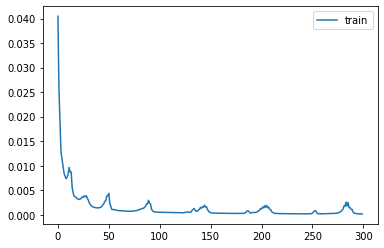

In [48]:
# Plot history
pyplot.plot(history_cnn.history['loss'], label='train')
pyplot.legend()
pyplot.show()

### Training des LSTM

In [49]:
# Train LSTM model with the best parameters from GridSearch
model_lstm_best = create_lstm_model(100, 'adam')
history_lstm = model_lstm_best.fit(X_train_lstm, y_train_lstm, epochs=300, batch_size=64, shuffle=False)

Epoch 1/300
7/7 [==============================] - 1s 8ms/step - loss: 0.0645
Epoch 2/300
7/7 [==============================] - 0s 9ms/step - loss: 0.0222
Epoch 3/300
7/7 [==============================] - 0s 10ms/step - loss: 0.0227
Epoch 4/300
7/7 [==============================] - 0s 10ms/step - loss: 0.0167
Epoch 5/300
7/7 [==============================] - 0s 10ms/step - loss: 0.0147
Epoch 6/300
7/7 [==============================] - 0s 11ms/step - loss: 0.0116
Epoch 7/300
7/7 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 8/300
7/7 [==============================] - 0s 10ms/step - loss: 0.0093
Epoch 9/300
7/7 [==============================] - 0s 11ms/step - loss: 0.0086
Epoch 10/300
7/7 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 11/300
7/7 [==============================] - 0s 9ms/step - loss: 0.0083
Epoch 12/300
7/7 [==============================] - 0s 9ms/step - loss: 0.0081
Epoch 13/300
7/7 [==============================] - 0s

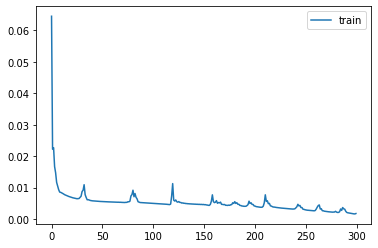

In [50]:
# Plot history
pyplot.plot(history_lstm.history['loss'], label='train')
pyplot.legend()
pyplot.show()

## Evaluation

### Evaluation des CNN

In [51]:
# Predict COVID-19 cases for test data
y_pred_cnn = model_cnn_best.predict(X_test_cnn)
mean_squared_error_cnn = mean_squared_error(y_test_cnn, y_pred_cnn)

In [52]:
print(f"mean squared error of CNN: {mean_squared_error_cnn}")

mean squared error of CNN: 0.04276322418064442


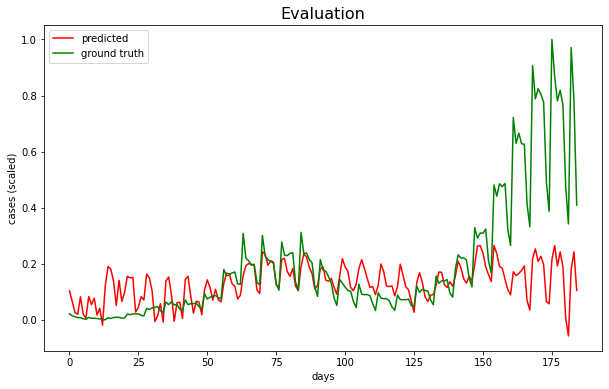

In [54]:
plt.figure(figsize=(10, 6))
plt.title("Evaluation", size=16)
plt.plot(y_pred_cnn, c="red", label='predicted')
plt.plot(y_test_cnn, c="green", label='ground truth')
plt.xlabel("days")
plt.ylabel("cases (scaled)")
plt.legend()
plt.show()

### Evaluation des LSTM

In [55]:
# Predict COVID-19 cases for test data
y_pred_lstm = model_lstm_best.predict(X_test_lstm)
mean_squared_error_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)

In [56]:
print(f"mean squared error of LSTM: {mean_squared_error_lstm}")

mean squared error of LSTM: 0.020564969243243143


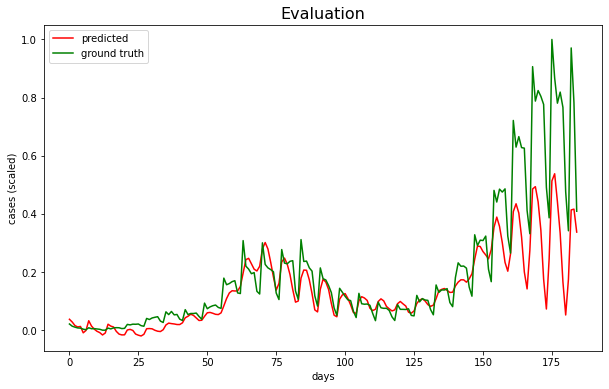

In [57]:
plt.figure(figsize=(10, 6))
plt.title("Evaluation", size=16)
plt.plot(y_pred_lstm, c="red", label='predicted')
plt.plot(y_test_lstm, c="green", label='ground truth')
plt.xlabel("days")
plt.ylabel("cases (scaled)")
plt.legend()
plt.show()